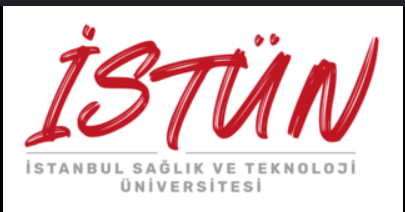

Göktürk Can 230611501 Computer Engineering

Ezgi Altıok 220611026 Computer Engineering

Kamil Sefa Cesur 220610024 Software Engineering

In [ ]:
import cv2
import numpy as np
import pytesseract

1. Image Capture or Loading (capture_frame_on_key)

Spacebar Press (Capture):

When the spacebar is pressed, the cv2.VideoCapture(0) function initializes a connection to your computer's primary webcam. The "0" argument typically denotes the default camera.
cap.read() then grabs a single frame from the webcam's video stream. This frame is essentially a snapshot of what the camera sees at that moment, represented as a multi-dimensional NumPy array of pixel values.

In [ ]:
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

def capture_frame_on_key(key=' '):
    """Captures a camera frame or loads an image when the specified key is pressed."""
    print("Press space to capture a new image or 'l' to load an existing image:")
    cap = cv2.VideoCapture(0)

    if not cap.isOpened():
        print("Error: Could not open camera.")
        return None

    while True:
        ret, frame = cap.read()
        if not ret:
            print("Error: Could not read frame.")
            break

        cv2.imshow('Press Space to Capture or L to Load', frame)

        key_pressed = cv2.waitKey(1) & 0xFF  # Get the key code
        if key_pressed == ord(key):
            cap.release()
            cv2.destroyAllWindows()
            return frame
        elif key_pressed == ord('l'):  # if l is pressed load a new image
            cap.release()
            cv2.destroyAllWindows()
            image_path = input("Enter the path to your image: ")
            return cv2.imread(image_path)  # load image from path
        if key_pressed == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()
    return None

2. Image Processing (process_image_for_numbers)

Conversion to Grayscale (cv2.cvtColor):

Purpose: Removes color information, leaving only the intensity (brightness) of each pixel. This is crucial because many image processing techniques operate more effectively on grayscale images, as they focus on analyzing the variations in pixel intensity rather than color nuances.

Why It Works: Color images typically use three channels (red, green, and blue) to represent each pixel. Converting to grayscale involves combining these channels into a single value, often using a weighted average. This simplifies the image data while preserving essential information about shapes and edges.

Gaussian Blurring (cv2.GaussianBlur):

Purpose: Smooths the image by replacing each pixel's value with a weighted average of its neighboring pixels. The weights are determined by a Gaussian function, which gives more importance to pixels closer to the center and less to those farther away.

Why It's Effective: Gaussian blurring is excellent at reducing noise, which are random fluctuations in pixel values. By averaging out these fluctuations, it makes it easier to identify the underlying structures and patterns in the image, such as the contours of numbers.

Kernel Size: The (5, 5) argument specifies the size of the Gaussian kernel, which is a matrix of weights. A larger kernel results in stronger blurring, but it might also obscure fine details. Choosing the right kernel size is a trade-off between noise reduction and preservation of details.

In [ ]:
def process_image_for_numbers(img):
    """Processes an image to detect numbers using various techniques."""
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

Adaptive Thresholding (cv2.adaptiveThreshold):

Purpose: Converts the grayscale image into a binary (black and white) image, where pixels above a certain threshold are set to white (255) and those below are set to black (0). Adaptive thresholding is a more sophisticated technique compared to simple thresholding because it calculates different thresholds for different regions of the image.

Why It's Better: In images with uneven lighting, a single threshold value might not be suitable for the entire image. Adaptive thresholding takes into account the local neighborhood of each pixel to determine its threshold, resulting in better separation of foreground (numbers) from background.

Method and Block Size: The cv2.ADAPTIVE_THRESH_GAUSSIAN_C method uses a Gaussian-weighted sum of the neighborhood to calculate the threshold. The 11 argument is the block size (neighborhood size), and 2 is a constant subtracted from the mean to fine-tune the threshold.

In [ ]:
 # Try different thresholding techniques
    thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)
    # Uncomment the following line to try simple binary thresholding
    # _, thresh = cv2.threshold(blurred, 128, 255, cv2.THRESH_BINARY_INV)

Contour Detection (cv2.findContours):

Purpose: Identifies the boundaries (contours) of white regions (potential numbers) in the binary image. A contour is essentially a curve joining all the continuous points along the boundary that have the same color or intensity.

Retrieval Mode (RETR_EXTERNAL): This mode specifies that we want to find only the outermost contours. In other words, if there are nested contours, we're interested in the largest one that encloses the others.

Approximation Method (CHAIN_APPROX_SIMPLE): This method simplifies the representation of each contour by eliminating redundant points. For example, a straight line segment is represented by its two endpoints instead of all the points along the line.

In [ ]:
 contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

Filtering and Merging Contours:

Purpose: Refines the list of contours by removing small, insignificant contours that might be noise and by merging contours that are very close to each other, as they likely belong to the same number.

Filtering by Area: Contours with an area smaller than a certain threshold (100 in this case) are discarded. This eliminates noise and focuses on the larger, more meaningful contours.

Merging Contours: This involves analyzing the bounding rectangles of contours. If two contours have significantly overlapping bounding boxes, they are merged into a single contour, ensuring that digits that are close together are treated as one unit.

In [ ]:
 # Merge close contours:
    merged_contours = []
    for contour in contours:
        if cv2.contourArea(contour) < 100:
            continue  # Ignore small contours
        (x, y, w, h) = cv2.boundingRect(contour)
        merged_contours.append((x, y, x + w, y + h))

Creating Number Regions:

Purpose: Determines the smallest rectangular region that encloses all the merged contours. This region defines the area where the numbers are located in the image.

Why It's Important: By isolating the number region, we can focus the subsequent optical character recognition (OCR) process on this specific area, improving the accuracy and efficiency of text extraction.

In [ ]:
if merged_contours:
        x_min = min(merged_contours, key=lambda b: b[0])[0]
        y_min = min(merged_contours, key=lambda b: b[1])[1]
        x_max = max(merged_contours, key=lambda b: b[2])[2]
        y_max = max(merged_contours, key=lambda b: b[3])[3]
        merged_rect = (x_min, y_min, x_max - x_min, y_max - y_min)
        number_regions = [merged_rect]
    else:
        number_regions = []

    return number_regions

Optical Character Recognition (OCR) (Continued):

Region of Interest (ROI) Extraction:

Purpose: Crops the number region from the original image, creating a smaller image that contains only the relevant information for OCR. This reduces computational load and improves OCR accuracy by eliminating distractions from the rest of the image.

How It Works: The bounding rectangle coordinates obtained in the previous step are used to slice the original image, extracting only the pixels within that rectangle.

In [ ]:
if captured_frame is not None:
    number_regions = process_image_for_numbers(captured_frame)

    for (x, y, w, h) in number_regions:
        # Draw rectangles around potential number regions (for visualization)
        cv2.rectangle(captured_frame, (x, y), (x + w, y + h), (0, 255, 0), 2)

Image Resizing and Denoising:

Resizing (cv2.resize): Enlarges the ROI to enhance the clarity of the numbers, making them easier for the OCR engine to recognize. The fx=2 and fy=2 arguments double the size of the ROI in both the horizontal and vertical directions.

Denoising (cv2.medianBlur): Reduces noise in the image by replacing each pixel value with the median value of its surrounding pixels. Median filtering is effective at removing salt-and-pepper noise while preserving sharp edges.

In [ ]:
 roi = captured_frame[y:y + h, x:x + w]
        roi = cv2.resize(roi, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)  # Rescale for better OCR
        roi = cv2.medianBlur(roi, 3)  # Denoise

Tesseract OCR with Improved Configuration:

Purpose: Employs the Tesseract OCR engine, a powerful open-source tool, to extract text from the preprocessed ROI. Tesseract analyzes the image and attempts to identify individual characters based on their shapes.

Configuration (config): The config string passes options to Tesseract:
--psm 7: Treats the image as a single line of text.
--oem 3: Uses the default OCR engine mode for the best possible accuracy.
-c tessedit_char_whitelist=0123456789: Restricts the recognized characters to digits 0-9, as we are only interested in numbers.

In [ ]:
 # Improved Tesseract Configuration:
        text = pytesseract.image_to_string(roi, config='--psm 7 --oem 3 -c tessedit_char_whitelist=0123456789')

Output and Visualization:

Purpose: Displays the results of the OCR process and provides visual feedback.
Printing Detected Numbers: The code prints each detected number along with its coordinates (x, y) within the original image. This helps you understand where the numbers are located.

Drawing Rectangles: Optionally, the code draws green rectangles around the detected number regions in the original image. This visual cue confirms the location of the recognized numbers.

In [ ]:
# Check for empty output:
        if text.strip():
            print(f"Detected Number at ({x}, {y}): {text.strip()}")

    # Display the result image (if needed)
    cv2.imshow("Detected Numbers", captured_frame)
    cv2.waitKey(0)

else:
    print("No image captured or loaded.")

The completed version of the Code:

In [ ]:
import cv2
import numpy as np
import pytesseract

# Define the Tesseract OCR path to execute Tesseract
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

def capture_frame_on_key(key=' '):
    """Captures a camera frame or loads an image when the specified key is pressed."""
    print("Press space to capture a new image or 'l' to load an existing image:")
    cap = cv2.VideoCapture(0)

    if not cap.isOpened():
        print("Error: Could not open camera.")
        return None

    while True:
        ret, frame = cap.read()
        if not ret:
            print("Error: Could not read frame.")
            break

        cv2.imshow('Press Space to Capture or L to Load', frame)

        key_pressed = cv2.waitKey(1) & 0xFF  # Get the key code
        if key_pressed == ord(key):
            cap.release()
            cv2.destroyAllWindows()
            return frame
        elif key_pressed == ord('l'):  # if l is pressed load a new image
            cap.release()
            cv2.destroyAllWindows()
            image_path = input("Enter the path to your image: ")
            return cv2.imread(image_path)  # load image from path
        if key_pressed == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()
    return None

def process_image_for_numbers(img):
    """Processes an image to detect numbers using various techniques."""
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Try different thresholding techniques
    thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)
    # Uncomment the following line to try simple binary thresholding
    # _, thresh = cv2.threshold(blurred, 128, 255, cv2.THRESH_BINARY_INV)

    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Merge close contours:
    merged_contours = []
    for contour in contours:
        if cv2.contourArea(contour) < 100:
            continue  # Ignore small contours
        (x, y, w, h) = cv2.boundingRect(contour)
        merged_contours.append((x, y, x + w, y + h))

    if merged_contours:
        x_min = min(merged_contours, key=lambda b: b[0])[0]
        y_min = min(merged_contours, key=lambda b: b[1])[1]
        x_max = max(merged_contours, key=lambda b: b[2])[2]
        y_max = max(merged_contours, key=lambda b: b[3])[3]
        merged_rect = (x_min, y_min, x_max - x_min, y_max - y_min)
        number_regions = [merged_rect]
    else:
        number_regions = []

    return number_regions

captured_frame = capture_frame_on_key(' ')

if captured_frame is not None:
    number_regions = process_image_for_numbers(captured_frame)

    for (x, y, w, h) in number_regions:
        # Draw rectangles around potential number regions (for visualization)
        cv2.rectangle(captured_frame, (x, y), (x + w, y + h), (0, 255, 0), 2)

        roi = captured_frame[y:y + h, x:x + w]
        roi = cv2.resize(roi, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)  # Rescale for better OCR
        roi = cv2.medianBlur(roi, 3)  # Denoise

        # Improved Tesseract Configuration:
        text = pytesseract.image_to_string(roi, config='--psm 7 --oem 3 -c tessedit_char_whitelist=0123456789')

        # Check for empty output:
        if text.strip():
            print(f"Detected Number at ({x}, {y}): {text.strip()}")

    # Display the result image (if needed)
    cv2.imshow("Detected Numbers", captured_frame)
    cv2.waitKey(0)

else:
    print("No image captured or loaded.")



References

Rosebrock, A. (2016, February 8). OpenCV shape detection. PyImageSearch. https://www.pyimagesearch.com/2016/02/08/opencv-shape-detection/

Rosebrock, A. (2014, April 21). Building a Pokédex in Python: Finding the game Boy screen (Steps 4-6). PyImageSearch. https://www.pyimagesearch.com/2014/04/21/building-pokedex-python-finding-game-boy-screen-step-4-6/

Rosebrock, A. (2015, June 15). Easily installing OpenCV 3.0 for Python 3 on OSX. PyImageSearch. https://www.pyimagesearch.com/2015/06/15/install-opencv-3-0-and-python-3-4-on-osx/

OpenCV. (n.d.). Image thresholding. In OpenCV documentation. Retrieved June 7, 2024, from https://docs.opencv.org/4.x/d7/d4d/tutorial_py_thresholding.html

OpenCV. (n.d.). Contours: Getting started. In OpenCV documentation. Retrieved June 7, 2024, from https://docs.opencv.org/4.x/d4/d73/tutorial_py_contours_begin.html

Tesseract OCR. (n.d.). Command-line usage. In Tesseract OCR GitHub Wiki. Retrieved June 7, 2024, from https://github.com/tesseract-ocr/tesseract/wiki/Command-Line-Usage#configuration-files

Gonzalez, R. C., & Woods, R. E. (2002). Digital image processing (2nd ed.). Upper Saddle River, NJ: Prentice Hall.

Jaderberg, M., Simonyan, K., Vedaldi, A., & Zisserman, A. (2015). Deep structured output learning for unconstrained text recognition. In International Conference on Learning Representations (ICLR).

Ciresan, D. C., Meier, U., Masci, J., & Schmidhuber, J. (2012). Multi-column deep neural networks for image classification. In 2012 IEEE Conference on Computer Vision and Pattern Recognition (pp. 3642-3649). IEEE.


